# ETF收益率预测系统演示

本笔记本将完整运行ETF预测系统，包含以下步骤：
1. 环境设置与依赖安装
2. 数据加载与预处理
3. 模型训练与参数调优
4. 回测评估
5. 可视化结果
6. 选基策略执行

## 1. 环境设置

In [1]:
import os
import sys
import shutil
from pathlib import Path

# GitHub 克隆仓库
!git clone https://github.com/ericwang0321/etf-prediction-system.git

# 项目根目录
project_root = Path("/content/etf-prediction-system")
os.chdir(project_root)

# 加入项目根目录到 sys.path
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

# 目录创建
os.makedirs('data', exist_ok=True)
os.makedirs('outputs/results', exist_ok=True)


Cloning into 'etf-prediction-system'...
remote: Enumerating objects: 1235, done.
remote: Counting objects: 100% (1235/1235), done.
remote: Compressing objects: 100% (1134/1134), done.
remote: Total 1235 (delta 99), reused 1222 (delta 91), pack-reused 0 (from 0)
Receiving objects: 100% (1235/1235), 5.74 MiB | 8.71 MiB/s, done.
Resolving deltas: 100% (99/99), done.


In [ ]:
#运行以下命令来安装 fonts-wqy-zenhei (文泉驿正黑字体)：
!sudo apt-get update
!sudo apt-get install -y fonts-wqy-zenhei

In [ ]:
!rm -rf ~/.cache/matplotlib

## 2. 安装依赖

运行`requirements.txt`文件

In [ ]:
import os

print("Changing directory to /content/etf-prediction-system and installing dependencies...")
os.chdir('/content/etf-prediction-system') # 切换到项目根目录

In [2]:
!pip install -r requirements.txt

INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
INFO: pip is looking at multiple versions of scipy to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 91.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 96.3 MB/s eta 0:00:00
   ━━━━━━━━━

## 3. 数据检查

In [1]:
import os
from pathlib import Path

# 定位到项目根目录
project_root = Path("/content/etf-prediction-system")
os.chdir(project_root)

print(os.getcwd())

/content/etf-prediction-system


In [2]:
from utils.data_loader import DataLoader

# 初始化数据加载器
data_loader = DataLoader(
    factor_path='data/factor_daily.csv',
    return_path='data/return_monthly.csv'
)

# 加载并检查数据
try:
    full_data = data_loader.load_and_merge_data()
    train_data, predict_data = data_loader.split_train_predict_data(full_data)

    print("数据加载成功！")
    print(f"训练数据形状: {train_data.shape}")
    print(f"预测数据形状: {predict_data.shape}")
    print("\n训练数据预览:")
    display(train_data.head())
except Exception as e:
    print(f"数据加载失败: {str(e)}")
    print("请检查data/目录下是否有正确的CSV文件")

数据加载成功！
训练数据形状: (4800, 29)
预测数据形状: (50, 29)

训练数据预览:


,datetime,sec_code,f1,f2,f3,f4,f5,f6,f7,f8,...,f18,f19,f20,f21,f22,f23,f24,f25,f26,target
0,2017-01-31,ACWI.O,0.693878,0.775510,0.200000,0.010204,1.000000,0.714286,0.142857,0.000000,...,0.224490,0.840909,0.204082,0.526316,0.693878,0.717391,-0.076744,4.480000e-16,0.777778,0.025127
1,2017-01-31,BIL.P,0.183673,0.367347,0.422222,0.010204,0.271186,0.612245,0.238095,0.020408,...,0.489796,0.704545,0.571429,0.778947,0.755102,0.108696,-0.415007,-3.007875e-01,0.513889,0.000494
2,2017-01-31,BNDX.O,0.142857,0.836735,0.000000,0.448980,1.000000,0.387755,0.928571,0.102041,...,0.734694,0.500000,0.591837,0.547368,0.428571,0.369565,-0.127222,-1.303163e+00,0.513889,0.008847
3,2017-01-31,BWX.P,0.081633,0.673469,0.866667,0.836735,1.000000,0.469388,0.571429,0.163265,...,0.285714,0.409091,0.479592,0.294737,0.469388,0.086957,0.066331,1.714125e+00,0.513889,0.003035
4,2017-01-31,CPER.P,0.346939,0.040816,0.466667,0.918367,0.067797,0.571429,0.571429,0.142857,...,0.673469,0.090909,0.918367,0.252632,0.061224,0.782609,-0.076744,4.480000e-16,0.027778,-0.010686


## 4. 系统配置

从config.py导入默认配置

In [3]:
from config import PARAM_GRIDS, TRAIN_WINDOWS

# 显示可用模型
print("可用模型:", list(PARAM_GRIDS.keys()))
print("训练窗口设置:", TRAIN_WINDOWS)

# 选择要运行的模型（默认全选）
MODELS_TO_RUN = list(PARAM_GRIDS.keys())

可用模型: ['xgboost', 'random_forest', 'lasso', 'lstm']
训练窗口设置: [12, 24, 36]


## 5. 模型训练与评估

In [5]:
from core.model import (
    XGBoostModel, RandomForestModel,
    LassoModel, LSTMModel
)
from core.trainer import ModelTrainer
from core.evaluator import ModelEvaluator
from core.selector import ETFSelector
from utils.visualize import ResultVisualizer
import pandas as pd
import numpy as np

# 初始化组件
evaluator = ModelEvaluator()
selector = ETFSelector(top_n=10)
visualizer = ResultVisualizer()

# 模型映射字典
MODEL_CLASSES = {
    'xgboost': XGBoostModel,
    'random_forest': RandomForestModel,
    'lasso': LassoModel,
    'lstm': LSTMModel
}

# 存储所有结果
all_results = []

# 动态获取要运行的模型名称 (推荐方式)
MODELS_TO_RUN = list(MODEL_CLASSES.keys())

for model_name in MODELS_TO_RUN:
    print(f"\n===== 开始处理 {model_name} 模型 =====")

    # 初始化模型实例，特别处理 LSTM 的 input_dim
    if model_name == 'lstm':
        # 确保 train_data 已在 Notebook 先前单元格中加载
        features_for_lstm = [col for col in train_data.columns if col not in ['datetime', 'sec_code', 'target']]
        lstm_input_dim = len(features_for_lstm)
        model = MODEL_CLASSES[model_name](input_dim=lstm_input_dim)
    else:
        model = MODEL_CLASSES[model_name]()

    # 获取特征列
    features = [col for col in train_data.columns
                if col not in ['datetime', 'sec_code', 'target']]

    # 参数调优
    trainer = ModelTrainer(model, PARAM_GRIDS[model_name])
    best_model, best_params = trainer.tune_hyperparameters(
        train_data[features], train_data['target']
    )
    print(f"最佳参数: {best_params}")

    # 测试不同训练窗口
    for window in TRAIN_WINDOWS:
        print(f"\n-- 测试 {window} 个月训练窗口 --")

        final_model, test_results = trainer.train_with_rolling_window(data_loader, window, train_data)

        # 评估
        metrics = evaluator.calculate_metrics(
            test_results['target'],
            test_results['pred'],
            test_results
        )
        print(evaluator.generate_report(metrics, model_name, window))

        # 存储结果
        all_results.append({
            'model': model_name,
            'window': window,
            **metrics
        })

        # 可视化
        visualizer.plot_pred_vs_real(
            test_results, model_name, window,
            f"outputs/results/pred_vs_real_{model_name}_{window}.png"
        )
        visualizer.plot_cs_ic_series(
            test_results, model_name, window,
            f"outputs/results/cs_ic_{model_name}_{window}.png"
        )

        # 最终预测
        X_predict = predict_data[features]
        X_processed = model.preprocess_data(X_predict)

        final_predictions = final_model.predict(X_processed)
        if isinstance(final_predictions, np.ndarray) and final_predictions.ndim > 1:
            final_predictions = final_predictions.flatten()

        # 复制 predict_data 以免在循环中被意外修改
        current_predict_data = predict_data.copy()
        current_predict_data['pred'] = final_predictions
        top_etfs = selector.select_top_etfs(current_predict_data)
        selector.save_selection(
            top_etfs,
            f"outputs/results/top_etfs_{model_name}_{window}.csv"
        )

        print(f"\nTop 10 ETF预览:")
        display(top_etfs.head())


===== 开始处理 xgboost 模型 =====
Fitting 3 folds for each of 8 candidates, totalling 24 fits
最佳参数: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}

-- 测试 12 个月训练窗口 --


/content/etf-prediction-system/utils/visualize.py:51: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from current font.
  plt.tight_layout()
/content/etf-prediction-system/utils/visualize.py:51: UserWarning: Glyph 26399 (\N{CJK UNIFIED IDEOGRAPH-671F}) missing from current font.
  plt.tight_layout()
/content/etf-prediction-system/utils/visualize.py:51: UserWarning: Glyph 25910 (\N{CJK UNIFIED IDEOGRAPH-6536}) missing from current font.
  plt.tight_layout()
/content/etf-prediction-system/utils/visualize.py:51: UserWarning: Glyph 30410 (\N{CJK UNIFIED IDEOGRAPH-76CA}) missing from current font.
  plt.tight_layout()
/content/etf-prediction-system/utils/visualize.py:51: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from current font.
  plt.tight_layout()
/content/etf-prediction-system/utils/visualize.py:51: UserWarning: Glyph 27169 (\N{CJK UNIFIED IDEOGRAPH-6A21}) missing from current font.
  plt.tight_layout()
/content/etf-prediction-system/utils/vis


===== xgboost 模型 (12个月窗口) 评估结果 =====
RMSE: 0.0597
R2: -0.1487
IC: -0.0073
CS-IC: 0.0258



/content/etf-prediction-system/utils/visualize.py:52: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from current font.
  plt.savefig(save_path)
/content/etf-prediction-system/utils/visualize.py:52: UserWarning: Glyph 26399 (\N{CJK UNIFIED IDEOGRAPH-671F}) missing from current font.
  plt.savefig(save_path)
/content/etf-prediction-system/utils/visualize.py:52: UserWarning: Glyph 25910 (\N{CJK UNIFIED IDEOGRAPH-6536}) missing from current font.
  plt.savefig(save_path)
/content/etf-prediction-system/utils/visualize.py:52: UserWarning: Glyph 30410 (\N{CJK UNIFIED IDEOGRAPH-76CA}) missing from current font.
  plt.savefig(save_path)
/content/etf-prediction-system/utils/visualize.py:52: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from current font.
  plt.savefig(save_path)
/content/etf-prediction-system/utils/visualize.py:52: UserWarning: Glyph 27169 (\N{CJK UNIFIED IDEOGRAPH-6A21}) missing from current font.
  plt.savefig(save_path)
/content/etf-pre


Top 10 ETF预览:


,datetime,sec_code,pred_return,target,weight
4840,2025-01-31,TLT.O,0.026376,NaN,0.1
4820,2025-01-31,GLD.P,0.020874,NaN,0.1
4807,2025-01-31,DVY.O,0.020753,NaN,0.1
4833,2025-01-31,PFF.O,0.017425,NaN,0.1
4815,2025-01-31,EWT.P,0.015648,NaN,0.1



-- 测试 24 个月训练窗口 --


/content/etf-prediction-system/utils/visualize.py:51: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from current font.
  plt.tight_layout()
/content/etf-prediction-system/utils/visualize.py:51: UserWarning: Glyph 26399 (\N{CJK UNIFIED IDEOGRAPH-671F}) missing from current font.
  plt.tight_layout()
/content/etf-prediction-system/utils/visualize.py:51: UserWarning: Glyph 25910 (\N{CJK UNIFIED IDEOGRAPH-6536}) missing from current font.
  plt.tight_layout()
/content/etf-prediction-system/utils/visualize.py:51: UserWarning: Glyph 30410 (\N{CJK UNIFIED IDEOGRAPH-76CA}) missing from current font.
  plt.tight_layout()
/content/etf-prediction-system/utils/visualize.py:51: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from current font.
  plt.tight_layout()
/content/etf-prediction-system/utils/visualize.py:51: UserWarning: Glyph 27169 (\N{CJK UNIFIED IDEOGRAPH-6A21}) missing from current font.
  plt.tight_layout()
/content/etf-prediction-system/utils/vis


===== xgboost 模型 (24个月窗口) 评估结果 =====
RMSE: 0.0593
R2: -0.0874
IC: 0.0066
CS-IC: 0.0500



/content/etf-prediction-system/utils/visualize.py:52: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from current font.
  plt.savefig(save_path)
/content/etf-prediction-system/utils/visualize.py:52: UserWarning: Glyph 26399 (\N{CJK UNIFIED IDEOGRAPH-671F}) missing from current font.
  plt.savefig(save_path)
/content/etf-prediction-system/utils/visualize.py:52: UserWarning: Glyph 25910 (\N{CJK UNIFIED IDEOGRAPH-6536}) missing from current font.
  plt.savefig(save_path)
/content/etf-prediction-system/utils/visualize.py:52: UserWarning: Glyph 30410 (\N{CJK UNIFIED IDEOGRAPH-76CA}) missing from current font.
  plt.savefig(save_path)
/content/etf-prediction-system/utils/visualize.py:52: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from current font.
  plt.savefig(save_path)
/content/etf-prediction-system/utils/visualize.py:52: UserWarning: Glyph 27169 (\N{CJK UNIFIED IDEOGRAPH-6A21}) missing from current font.
  plt.savefig(save_path)
/content/etf-pre


Top 10 ETF预览:


,datetime,sec_code,pred_return,target,weight
4845,2025-01-31,VONG.O,0.043859,NaN,0.1
4807,2025-01-31,DVY.O,0.041984,NaN,0.1
4824,2025-01-31,ICLN.O,0.041092,NaN,0.1
4828,2025-01-31,INDA.B,0.040620,NaN,0.1
4800,2025-01-31,ACWI.O,0.039761,NaN,0.1



-- 测试 36 个月训练窗口 --


/content/etf-prediction-system/utils/visualize.py:51: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from current font.
  plt.tight_layout()
/content/etf-prediction-system/utils/visualize.py:51: UserWarning: Glyph 26399 (\N{CJK UNIFIED IDEOGRAPH-671F}) missing from current font.
  plt.tight_layout()
/content/etf-prediction-system/utils/visualize.py:51: UserWarning: Glyph 25910 (\N{CJK UNIFIED IDEOGRAPH-6536}) missing from current font.
  plt.tight_layout()
/content/etf-prediction-system/utils/visualize.py:51: UserWarning: Glyph 30410 (\N{CJK UNIFIED IDEOGRAPH-76CA}) missing from current font.
  plt.tight_layout()
/content/etf-prediction-system/utils/visualize.py:51: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from current font.
  plt.tight_layout()
/content/etf-prediction-system/utils/visualize.py:51: UserWarning: Glyph 27169 (\N{CJK UNIFIED IDEOGRAPH-6A21}) missing from current font.
  plt.tight_layout()
/content/etf-prediction-system/utils/vis


===== xgboost 模型 (36个月窗口) 评估结果 =====
RMSE: 0.0614
R2: -0.0590
IC: -0.0187
CS-IC: 0.0380



/content/etf-prediction-system/utils/visualize.py:52: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from current font.
  plt.savefig(save_path)
/content/etf-prediction-system/utils/visualize.py:52: UserWarning: Glyph 26399 (\N{CJK UNIFIED IDEOGRAPH-671F}) missing from current font.
  plt.savefig(save_path)
/content/etf-prediction-system/utils/visualize.py:52: UserWarning: Glyph 25910 (\N{CJK UNIFIED IDEOGRAPH-6536}) missing from current font.
  plt.savefig(save_path)
/content/etf-prediction-system/utils/visualize.py:52: UserWarning: Glyph 30410 (\N{CJK UNIFIED IDEOGRAPH-76CA}) missing from current font.
  plt.savefig(save_path)
/content/etf-prediction-system/utils/visualize.py:52: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from current font.
  plt.savefig(save_path)
/content/etf-prediction-system/utils/visualize.py:52: UserWarning: Glyph 27169 (\N{CJK UNIFIED IDEOGRAPH-6A21}) missing from current font.
  plt.savefig(save_path)
/content/etf-pre


Top 10 ETF预览:


,datetime,sec_code,pred_return,target,weight
4834,2025-01-31,QQQ.O,0.039239,NaN,0.1
4845,2025-01-31,VONG.O,0.033269,NaN,0.1
4829,2025-01-31,IUSG.O,0.025316,NaN,0.1
4828,2025-01-31,INDA.B,0.017993,NaN,0.1
4807,2025-01-31,DVY.O,0.004112,NaN,0.1



===== 开始处理 random_forest 模型 =====
Fitting 3 folds for each of 4 candidates, totalling 12 fits
最佳参数: {'max_depth': 3, 'n_estimators': 50}

-- 测试 12 个月训练窗口 --


/content/etf-prediction-system/utils/visualize.py:51: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from current font.
  plt.tight_layout()
/content/etf-prediction-system/utils/visualize.py:51: UserWarning: Glyph 26399 (\N{CJK UNIFIED IDEOGRAPH-671F}) missing from current font.
  plt.tight_layout()
/content/etf-prediction-system/utils/visualize.py:51: UserWarning: Glyph 25910 (\N{CJK UNIFIED IDEOGRAPH-6536}) missing from current font.
  plt.tight_layout()
/content/etf-prediction-system/utils/visualize.py:51: UserWarning: Glyph 30410 (\N{CJK UNIFIED IDEOGRAPH-76CA}) missing from current font.
  plt.tight_layout()
/content/etf-prediction-system/utils/visualize.py:51: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from current font.
  plt.tight_layout()
/content/etf-prediction-system/utils/visualize.py:51: UserWarning: Glyph 27169 (\N{CJK UNIFIED IDEOGRAPH-6A21}) missing from current font.
  plt.tight_layout()
/content/etf-prediction-system/utils/vis


===== random_forest 模型 (12个月窗口) 评估结果 =====
RMSE: 0.0590
R2: -0.1212
IC: -0.0776
CS-IC: -0.0068



/content/etf-prediction-system/utils/visualize.py:52: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from current font.
  plt.savefig(save_path)
/content/etf-prediction-system/utils/visualize.py:52: UserWarning: Glyph 26399 (\N{CJK UNIFIED IDEOGRAPH-671F}) missing from current font.
  plt.savefig(save_path)
/content/etf-prediction-system/utils/visualize.py:52: UserWarning: Glyph 25910 (\N{CJK UNIFIED IDEOGRAPH-6536}) missing from current font.
  plt.savefig(save_path)
/content/etf-prediction-system/utils/visualize.py:52: UserWarning: Glyph 30410 (\N{CJK UNIFIED IDEOGRAPH-76CA}) missing from current font.
  plt.savefig(save_path)
/content/etf-prediction-system/utils/visualize.py:52: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from current font.
  plt.savefig(save_path)
/content/etf-prediction-system/utils/visualize.py:52: UserWarning: Glyph 27169 (\N{CJK UNIFIED IDEOGRAPH-6A21}) missing from current font.
  plt.savefig(save_path)
/content/etf-pre


Top 10 ETF预览:


,datetime,sec_code,pred_return,target,weight
4806,2025-01-31,DBA.P,0.041237,NaN,0.1
4840,2025-01-31,TLT.O,0.015955,NaN,0.1
4830,2025-01-31,KSA.P,0.009434,NaN,0.1
4815,2025-01-31,EWT.P,0.008745,NaN,0.1
4841,2025-01-31,USO.P,0.007730,NaN,0.1



-- 测试 24 个月训练窗口 --


/content/etf-prediction-system/utils/visualize.py:51: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from current font.
  plt.tight_layout()
/content/etf-prediction-system/utils/visualize.py:51: UserWarning: Glyph 26399 (\N{CJK UNIFIED IDEOGRAPH-671F}) missing from current font.
  plt.tight_layout()
/content/etf-prediction-system/utils/visualize.py:51: UserWarning: Glyph 25910 (\N{CJK UNIFIED IDEOGRAPH-6536}) missing from current font.
  plt.tight_layout()
/content/etf-prediction-system/utils/visualize.py:51: UserWarning: Glyph 30410 (\N{CJK UNIFIED IDEOGRAPH-76CA}) missing from current font.
  plt.tight_layout()
/content/etf-prediction-system/utils/visualize.py:51: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from current font.
  plt.tight_layout()
/content/etf-prediction-system/utils/visualize.py:51: UserWarning: Glyph 27169 (\N{CJK UNIFIED IDEOGRAPH-6A21}) missing from current font.
  plt.tight_layout()
/content/etf-prediction-system/utils/vis


===== random_forest 模型 (24个月窗口) 评估结果 =====
RMSE: 0.0589
R2: -0.0710
IC: -0.1246
CS-IC: 0.0075



/content/etf-prediction-system/utils/visualize.py:52: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from current font.
  plt.savefig(save_path)
/content/etf-prediction-system/utils/visualize.py:52: UserWarning: Glyph 26399 (\N{CJK UNIFIED IDEOGRAPH-671F}) missing from current font.
  plt.savefig(save_path)
/content/etf-prediction-system/utils/visualize.py:52: UserWarning: Glyph 25910 (\N{CJK UNIFIED IDEOGRAPH-6536}) missing from current font.
  plt.savefig(save_path)
/content/etf-prediction-system/utils/visualize.py:52: UserWarning: Glyph 30410 (\N{CJK UNIFIED IDEOGRAPH-76CA}) missing from current font.
  plt.savefig(save_path)
/content/etf-prediction-system/utils/visualize.py:52: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from current font.
  plt.savefig(save_path)
/content/etf-prediction-system/utils/visualize.py:52: UserWarning: Glyph 27169 (\N{CJK UNIFIED IDEOGRAPH-6A21}) missing from current font.
  plt.savefig(save_path)
/content/etf-pre


Top 10 ETF预览:


,datetime,sec_code,pred_return,target,weight
4838,2025-01-31,SPY.P,0.024167,NaN,0.1
4807,2025-01-31,DVY.O,0.024073,NaN,0.1
4828,2025-01-31,INDA.B,0.022624,NaN,0.1
4800,2025-01-31,ACWI.O,0.021935,NaN,0.1
4845,2025-01-31,VONG.O,0.021187,NaN,0.1



-- 测试 36 个月训练窗口 --


/content/etf-prediction-system/utils/visualize.py:51: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from current font.
  plt.tight_layout()
/content/etf-prediction-system/utils/visualize.py:51: UserWarning: Glyph 26399 (\N{CJK UNIFIED IDEOGRAPH-671F}) missing from current font.
  plt.tight_layout()
/content/etf-prediction-system/utils/visualize.py:51: UserWarning: Glyph 25910 (\N{CJK UNIFIED IDEOGRAPH-6536}) missing from current font.
  plt.tight_layout()
/content/etf-prediction-system/utils/visualize.py:51: UserWarning: Glyph 30410 (\N{CJK UNIFIED IDEOGRAPH-76CA}) missing from current font.
  plt.tight_layout()
/content/etf-prediction-system/utils/visualize.py:51: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from current font.
  plt.tight_layout()
/content/etf-prediction-system/utils/visualize.py:51: UserWarning: Glyph 27169 (\N{CJK UNIFIED IDEOGRAPH-6A21}) missing from current font.
  plt.tight_layout()
/content/etf-prediction-system/utils/vis


===== random_forest 模型 (36个月窗口) 评估结果 =====
RMSE: 0.0610
R2: -0.0437
IC: -0.0844
CS-IC: 0.0213



/content/etf-prediction-system/utils/visualize.py:52: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from current font.
  plt.savefig(save_path)
/content/etf-prediction-system/utils/visualize.py:52: UserWarning: Glyph 26399 (\N{CJK UNIFIED IDEOGRAPH-671F}) missing from current font.
  plt.savefig(save_path)
/content/etf-prediction-system/utils/visualize.py:52: UserWarning: Glyph 25910 (\N{CJK UNIFIED IDEOGRAPH-6536}) missing from current font.
  plt.savefig(save_path)
/content/etf-prediction-system/utils/visualize.py:52: UserWarning: Glyph 30410 (\N{CJK UNIFIED IDEOGRAPH-76CA}) missing from current font.
  plt.savefig(save_path)
/content/etf-prediction-system/utils/visualize.py:52: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from current font.
  plt.savefig(save_path)
/content/etf-prediction-system/utils/visualize.py:52: UserWarning: Glyph 27169 (\N{CJK UNIFIED IDEOGRAPH-6A21}) missing from current font.
  plt.savefig(save_path)
/content/etf-pre


Top 10 ETF预览:


,datetime,sec_code,pred_return,target,weight
4834,2025-01-31,QQQ.O,0.026589,NaN,0.1
4845,2025-01-31,VONG.O,0.023785,NaN,0.1
4828,2025-01-31,INDA.B,0.021196,NaN,0.1
4829,2025-01-31,IUSG.O,0.019058,NaN,0.1
4830,2025-01-31,KSA.P,0.014114,NaN,0.1



===== 开始处理 lasso 模型 =====
Fitting 3 folds for each of 3 candidates, totalling 9 fits
最佳参数: {'alpha': 0.0001}

-- 测试 12 个月训练窗口 --


/content/etf-prediction-system/utils/visualize.py:51: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from current font.
  plt.tight_layout()
/content/etf-prediction-system/utils/visualize.py:51: UserWarning: Glyph 26399 (\N{CJK UNIFIED IDEOGRAPH-671F}) missing from current font.
  plt.tight_layout()
/content/etf-prediction-system/utils/visualize.py:51: UserWarning: Glyph 25910 (\N{CJK UNIFIED IDEOGRAPH-6536}) missing from current font.
  plt.tight_layout()
/content/etf-prediction-system/utils/visualize.py:51: UserWarning: Glyph 30410 (\N{CJK UNIFIED IDEOGRAPH-76CA}) missing from current font.
  plt.tight_layout()
/content/etf-prediction-system/utils/visualize.py:51: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from current font.
  plt.tight_layout()
/content/etf-prediction-system/utils/visualize.py:51: UserWarning: Glyph 27169 (\N{CJK UNIFIED IDEOGRAPH-6A21}) missing from current font.
  plt.tight_layout()
/content/etf-prediction-system/utils/vis


===== lasso 模型 (12个月窗口) 评估结果 =====
RMSE: 0.0589
R2: -0.1175
IC: -0.0189
CS-IC: 0.0337



/content/etf-prediction-system/utils/visualize.py:52: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from current font.
  plt.savefig(save_path)
/content/etf-prediction-system/utils/visualize.py:52: UserWarning: Glyph 26399 (\N{CJK UNIFIED IDEOGRAPH-671F}) missing from current font.
  plt.savefig(save_path)
/content/etf-prediction-system/utils/visualize.py:52: UserWarning: Glyph 25910 (\N{CJK UNIFIED IDEOGRAPH-6536}) missing from current font.
  plt.savefig(save_path)
/content/etf-prediction-system/utils/visualize.py:52: UserWarning: Glyph 30410 (\N{CJK UNIFIED IDEOGRAPH-76CA}) missing from current font.
  plt.savefig(save_path)
/content/etf-prediction-system/utils/visualize.py:52: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from current font.
  plt.savefig(save_path)
/content/etf-prediction-system/utils/visualize.py:52: UserWarning: Glyph 27169 (\N{CJK UNIFIED IDEOGRAPH-6A21}) missing from current font.
  plt.savefig(save_path)
/content/etf-pre


Top 10 ETF预览:


,datetime,sec_code,pred_return,target,weight
4815,2025-01-31,EWT.P,0.023364,NaN,0.1
4800,2025-01-31,ACWI.O,0.015526,NaN,0.1
4833,2025-01-31,PFF.O,0.014574,NaN,0.1
4838,2025-01-31,SPY.P,0.014429,NaN,0.1
4842,2025-01-31,VCLT.O,0.014393,NaN,0.1



-- 测试 24 个月训练窗口 --


/content/etf-prediction-system/utils/visualize.py:51: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from current font.
  plt.tight_layout()
/content/etf-prediction-system/utils/visualize.py:51: UserWarning: Glyph 26399 (\N{CJK UNIFIED IDEOGRAPH-671F}) missing from current font.
  plt.tight_layout()
/content/etf-prediction-system/utils/visualize.py:51: UserWarning: Glyph 25910 (\N{CJK UNIFIED IDEOGRAPH-6536}) missing from current font.
  plt.tight_layout()
/content/etf-prediction-system/utils/visualize.py:51: UserWarning: Glyph 30410 (\N{CJK UNIFIED IDEOGRAPH-76CA}) missing from current font.
  plt.tight_layout()
/content/etf-prediction-system/utils/visualize.py:51: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from current font.
  plt.tight_layout()
/content/etf-prediction-system/utils/visualize.py:51: UserWarning: Glyph 27169 (\N{CJK UNIFIED IDEOGRAPH-6A21}) missing from current font.
  plt.tight_layout()
/content/etf-prediction-system/utils/vis


===== lasso 模型 (24个月窗口) 评估结果 =====
RMSE: 0.0585
R2: -0.0590
IC: -0.0210
CS-IC: 0.0530



/content/etf-prediction-system/utils/visualize.py:52: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from current font.
  plt.savefig(save_path)
/content/etf-prediction-system/utils/visualize.py:52: UserWarning: Glyph 26399 (\N{CJK UNIFIED IDEOGRAPH-671F}) missing from current font.
  plt.savefig(save_path)
/content/etf-prediction-system/utils/visualize.py:52: UserWarning: Glyph 25910 (\N{CJK UNIFIED IDEOGRAPH-6536}) missing from current font.
  plt.savefig(save_path)
/content/etf-prediction-system/utils/visualize.py:52: UserWarning: Glyph 30410 (\N{CJK UNIFIED IDEOGRAPH-76CA}) missing from current font.
  plt.savefig(save_path)
/content/etf-prediction-system/utils/visualize.py:52: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from current font.
  plt.savefig(save_path)
/content/etf-prediction-system/utils/visualize.py:52: UserWarning: Glyph 27169 (\N{CJK UNIFIED IDEOGRAPH-6A21}) missing from current font.
  plt.savefig(save_path)
/content/etf-pre


Top 10 ETF预览:


,datetime,sec_code,pred_return,target,weight
4800,2025-01-31,ACWI.O,0.027251,NaN,0.1
4834,2025-01-31,QQQ.O,0.024488,NaN,0.1
4814,2025-01-31,EWQ.P,0.023481,NaN,0.1
4815,2025-01-31,EWT.P,0.020129,NaN,0.1
4811,2025-01-31,EWG.P,0.018037,NaN,0.1



-- 测试 36 个月训练窗口 --


/content/etf-prediction-system/utils/visualize.py:51: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from current font.
  plt.tight_layout()
/content/etf-prediction-system/utils/visualize.py:51: UserWarning: Glyph 26399 (\N{CJK UNIFIED IDEOGRAPH-671F}) missing from current font.
  plt.tight_layout()
/content/etf-prediction-system/utils/visualize.py:51: UserWarning: Glyph 25910 (\N{CJK UNIFIED IDEOGRAPH-6536}) missing from current font.
  plt.tight_layout()
/content/etf-prediction-system/utils/visualize.py:51: UserWarning: Glyph 30410 (\N{CJK UNIFIED IDEOGRAPH-76CA}) missing from current font.
  plt.tight_layout()
/content/etf-prediction-system/utils/visualize.py:51: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from current font.
  plt.tight_layout()
/content/etf-prediction-system/utils/visualize.py:51: UserWarning: Glyph 27169 (\N{CJK UNIFIED IDEOGRAPH-6A21}) missing from current font.
  plt.tight_layout()
/content/etf-prediction-system/utils/vis


===== lasso 模型 (36个月窗口) 评估结果 =====
RMSE: 0.0609
R2: -0.0394
IC: -0.0176
CS-IC: 0.0606



/content/etf-prediction-system/utils/visualize.py:52: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from current font.
  plt.savefig(save_path)
/content/etf-prediction-system/utils/visualize.py:52: UserWarning: Glyph 26399 (\N{CJK UNIFIED IDEOGRAPH-671F}) missing from current font.
  plt.savefig(save_path)
/content/etf-prediction-system/utils/visualize.py:52: UserWarning: Glyph 25910 (\N{CJK UNIFIED IDEOGRAPH-6536}) missing from current font.
  plt.savefig(save_path)
/content/etf-prediction-system/utils/visualize.py:52: UserWarning: Glyph 30410 (\N{CJK UNIFIED IDEOGRAPH-76CA}) missing from current font.
  plt.savefig(save_path)
/content/etf-prediction-system/utils/visualize.py:52: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from current font.
  plt.savefig(save_path)
/content/etf-prediction-system/utils/visualize.py:52: UserWarning: Glyph 27169 (\N{CJK UNIFIED IDEOGRAPH-6A21}) missing from current font.
  plt.savefig(save_path)
/content/etf-pre


Top 10 ETF预览:


,datetime,sec_code,pred_return,target,weight
4834,2025-01-31,QQQ.O,0.017853,NaN,0.1
4815,2025-01-31,EWT.P,0.016669,NaN,0.1
4838,2025-01-31,SPY.P,0.012082,NaN,0.1
4837,2025-01-31,SMH.P,0.010732,NaN,0.1
4845,2025-01-31,VONG.O,0.008998,NaN,0.1



===== 开始处理 lstm 模型 =====
Fitting 3 folds for each of 32 candidates, totalling 96 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


最佳参数: {'batch_size': 32, 'epochs': 5, 'model__dropout_rate': 0.3, 'model__learning_rate': 0.001, 'model__units': 32, 'verbose': 0}

-- 测试 12 个月训练窗口 --


/content/etf-prediction-system/utils/visualize.py:51: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from current font.
  plt.tight_layout()
/content/etf-prediction-system/utils/visualize.py:51: UserWarning: Glyph 26399 (\N{CJK UNIFIED IDEOGRAPH-671F}) missing from current font.
  plt.tight_layout()
/content/etf-prediction-system/utils/visualize.py:51: UserWarning: Glyph 25910 (\N{CJK UNIFIED IDEOGRAPH-6536}) missing from current font.
  plt.tight_layout()
/content/etf-prediction-system/utils/visualize.py:51: UserWarning: Glyph 30410 (\N{CJK UNIFIED IDEOGRAPH-76CA}) missing from current font.
  plt.tight_layout()
/content/etf-prediction-system/utils/visualize.py:51: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from current font.
  plt.tight_layout()
/content/etf-prediction-system/utils/visualize.py:51: UserWarning: Glyph 27169 (\N{CJK UNIFIED IDEOGRAPH-6A21}) missing from current font.
  plt.tight_layout()
/content/etf-prediction-system/utils/vis


===== lstm 模型 (12个月窗口) 评估结果 =====
RMSE: 0.0603
R2: -0.1733
IC: -0.0450
CS-IC: -0.0166



/content/etf-prediction-system/utils/visualize.py:52: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from current font.
  plt.savefig(save_path)
/content/etf-prediction-system/utils/visualize.py:52: UserWarning: Glyph 26399 (\N{CJK UNIFIED IDEOGRAPH-671F}) missing from current font.
  plt.savefig(save_path)
/content/etf-prediction-system/utils/visualize.py:52: UserWarning: Glyph 25910 (\N{CJK UNIFIED IDEOGRAPH-6536}) missing from current font.
  plt.savefig(save_path)
/content/etf-prediction-system/utils/visualize.py:52: UserWarning: Glyph 30410 (\N{CJK UNIFIED IDEOGRAPH-76CA}) missing from current font.
  plt.savefig(save_path)
/content/etf-prediction-system/utils/visualize.py:52: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from current font.
  plt.savefig(save_path)
/content/etf-prediction-system/utils/visualize.py:52: UserWarning: Glyph 27169 (\N{CJK UNIFIED IDEOGRAPH-6A21}) missing from current font.
  plt.savefig(save_path)
/content/etf-pre


Top 10 ETF预览:


,datetime,sec_code,pred_return,target,weight
4825,2025-01-31,IEF.O,0.042110,NaN,0.1
4807,2025-01-31,DVY.O,0.036732,NaN,0.1
4824,2025-01-31,ICLN.O,0.032450,NaN,0.1
4840,2025-01-31,TLT.O,0.031782,NaN,0.1
4832,2025-01-31,MCHI.O,0.025404,NaN,0.1



-- 测试 24 个月训练窗口 --


/content/etf-prediction-system/utils/visualize.py:51: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from current font.
  plt.tight_layout()
/content/etf-prediction-system/utils/visualize.py:51: UserWarning: Glyph 26399 (\N{CJK UNIFIED IDEOGRAPH-671F}) missing from current font.
  plt.tight_layout()
/content/etf-prediction-system/utils/visualize.py:51: UserWarning: Glyph 25910 (\N{CJK UNIFIED IDEOGRAPH-6536}) missing from current font.
  plt.tight_layout()
/content/etf-prediction-system/utils/visualize.py:51: UserWarning: Glyph 30410 (\N{CJK UNIFIED IDEOGRAPH-76CA}) missing from current font.
  plt.tight_layout()
/content/etf-prediction-system/utils/visualize.py:51: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from current font.
  plt.tight_layout()
/content/etf-prediction-system/utils/visualize.py:51: UserWarning: Glyph 27169 (\N{CJK UNIFIED IDEOGRAPH-6A21}) missing from current font.
  plt.tight_layout()
/content/etf-prediction-system/utils/vis


===== lstm 模型 (24个月窗口) 评估结果 =====
RMSE: 0.0590
R2: -0.0768
IC: -0.0012
CS-IC: 0.0491



/content/etf-prediction-system/utils/visualize.py:52: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from current font.
  plt.savefig(save_path)
/content/etf-prediction-system/utils/visualize.py:52: UserWarning: Glyph 26399 (\N{CJK UNIFIED IDEOGRAPH-671F}) missing from current font.
  plt.savefig(save_path)
/content/etf-prediction-system/utils/visualize.py:52: UserWarning: Glyph 25910 (\N{CJK UNIFIED IDEOGRAPH-6536}) missing from current font.
  plt.savefig(save_path)
/content/etf-prediction-system/utils/visualize.py:52: UserWarning: Glyph 30410 (\N{CJK UNIFIED IDEOGRAPH-76CA}) missing from current font.
  plt.savefig(save_path)
/content/etf-prediction-system/utils/visualize.py:52: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from current font.
  plt.savefig(save_path)
/content/etf-prediction-system/utils/visualize.py:52: UserWarning: Glyph 27169 (\N{CJK UNIFIED IDEOGRAPH-6A21}) missing from current font.
  plt.savefig(save_path)
/content/etf-pre


Top 10 ETF预览:


,datetime,sec_code,pred_return,target,weight
4806,2025-01-31,DBA.P,0.030317,NaN,0.1
4801,2025-01-31,BIL.P,0.030275,NaN,0.1
4807,2025-01-31,DVY.O,0.029433,NaN,0.1
4800,2025-01-31,ACWI.O,0.029404,NaN,0.1
4802,2025-01-31,BNDX.O,0.024454,NaN,0.1



-- 测试 36 个月训练窗口 --


/content/etf-prediction-system/utils/visualize.py:51: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from current font.
  plt.tight_layout()
/content/etf-prediction-system/utils/visualize.py:51: UserWarning: Glyph 26399 (\N{CJK UNIFIED IDEOGRAPH-671F}) missing from current font.
  plt.tight_layout()
/content/etf-prediction-system/utils/visualize.py:51: UserWarning: Glyph 25910 (\N{CJK UNIFIED IDEOGRAPH-6536}) missing from current font.
  plt.tight_layout()
/content/etf-prediction-system/utils/visualize.py:51: UserWarning: Glyph 30410 (\N{CJK UNIFIED IDEOGRAPH-76CA}) missing from current font.
  plt.tight_layout()
/content/etf-prediction-system/utils/visualize.py:51: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from current font.
  plt.tight_layout()
/content/etf-prediction-system/utils/visualize.py:51: UserWarning: Glyph 27169 (\N{CJK UNIFIED IDEOGRAPH-6A21}) missing from current font.
  plt.tight_layout()
/content/etf-prediction-system/utils/vis


===== lstm 模型 (36个月窗口) 评估结果 =====
RMSE: 0.0620
R2: -0.0770
IC: -0.0786
CS-IC: 0.0293



/content/etf-prediction-system/utils/visualize.py:52: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from current font.
  plt.savefig(save_path)
/content/etf-prediction-system/utils/visualize.py:52: UserWarning: Glyph 26399 (\N{CJK UNIFIED IDEOGRAPH-671F}) missing from current font.
  plt.savefig(save_path)
/content/etf-prediction-system/utils/visualize.py:52: UserWarning: Glyph 25910 (\N{CJK UNIFIED IDEOGRAPH-6536}) missing from current font.
  plt.savefig(save_path)
/content/etf-prediction-system/utils/visualize.py:52: UserWarning: Glyph 30410 (\N{CJK UNIFIED IDEOGRAPH-76CA}) missing from current font.
  plt.savefig(save_path)
/content/etf-prediction-system/utils/visualize.py:52: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from current font.
  plt.savefig(save_path)
/content/etf-prediction-system/utils/visualize.py:52: UserWarning: Glyph 27169 (\N{CJK UNIFIED IDEOGRAPH-6A21}) missing from current font.
  plt.savefig(save_path)
/content/etf-pre


Top 10 ETF预览:


,datetime,sec_code,pred_return,target,weight
4834,2025-01-31,QQQ.O,0.018668,NaN,0.1
4845,2025-01-31,VONG.O,0.017764,NaN,0.1
4815,2025-01-31,EWT.P,0.016134,NaN,0.1
4838,2025-01-31,SPY.P,0.014317,NaN,0.1
4833,2025-01-31,PFF.O,0.013474,NaN,0.1


## 6. 结果汇总

In [6]:
# 将所有结果保存为CSV
results_df = pd.DataFrame(all_results)
results_df.to_csv("outputs/results/all_results.csv", index=False)

print("\n===== 所有模型评估结果汇总 =====")
display(results_df)

# 找出每个模型的最佳配置
best_configs = []
for model_name in MODELS_TO_RUN:
    model_results = results_df[results_df['model'] == model_name]
    if not model_results.empty:
        # 优先按CS-IC排序，其次按R2
        best_idx = model_results['CS-IC'].fillna(-np.inf).idxmax()
        if np.isinf(model_results.loc[best_idx, 'CS-IC']):
            best_idx = model_results['R2'].idxmax()
        best_configs.append(model_results.loc[best_idx])

if best_configs:
    print("\n===== 最佳配置推荐 =====")
    best_df = pd.DataFrame(best_configs)
    display(best_df)
else:
    print("没有找到有效的配置结果")


===== 所有模型评估结果汇总 =====


,model,window,RMSE,R2,IC,CS-IC
0,xgboost,12,0.059678,-0.148669,-0.007349,0.025807
1,xgboost,24,0.059321,-0.087393,0.006629,0.050028
2,xgboost,36,0.061433,-0.059025,-0.018730,0.038011
3,random_forest,12,0.058959,-0.121151,-0.077611,-0.006794
4,random_forest,24,0.058872,-0.071013,-0.124615,0.007461
5,random_forest,36,0.060987,-0.043680,-0.084439,0.021288
6,lasso,12,0.058862,-0.117460,-0.018862,0.033705
7,lasso,24,0.058542,-0.059034,-0.020958,0.053012
8,lasso,36,0.060861,-0.039368,-0.017633,0.060578
9,lstm,12,0.060313,-0.173260,-0.044967,-0.016555



===== 最佳配置推荐 =====


,model,window,RMSE,R2,IC,CS-IC
1,xgboost,24,0.059321,-0.087393,0.006629,0.050028
5,random_forest,36,0.060987,-0.043680,-0.084439,0.021288
8,lasso,36,0.060861,-0.039368,-0.017633,0.060578
10,lstm,24,0.059032,-0.076843,-0.001153,0.049057


## 7. 结果可视化


xgboost (12个月窗口) - 预测vs真实值


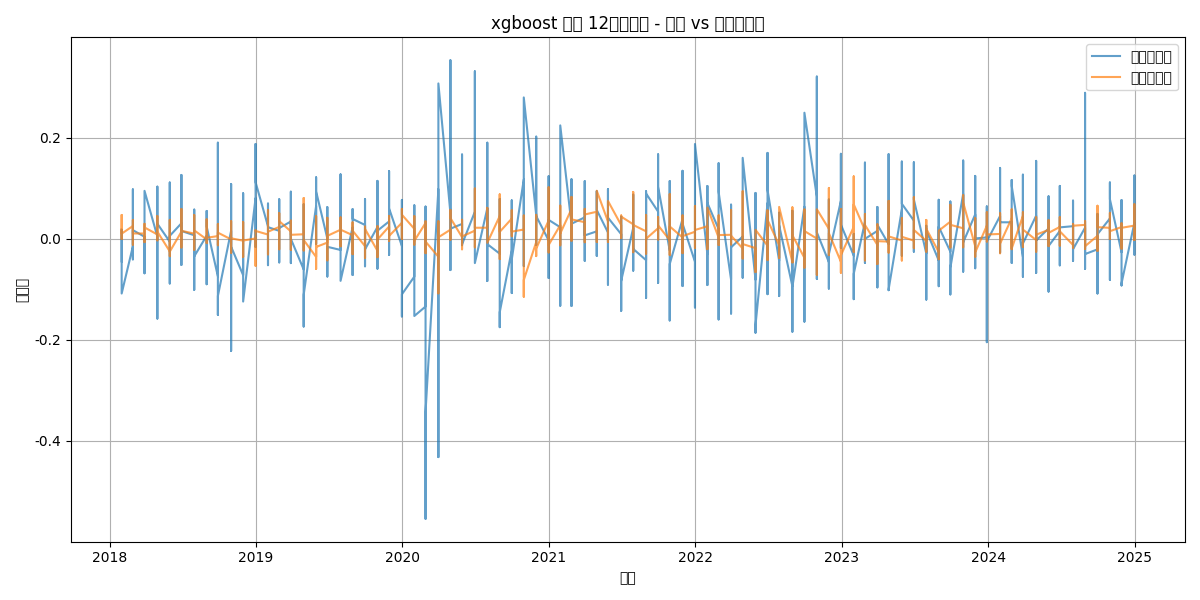


xgboost (12个月窗口) - IC时间序列


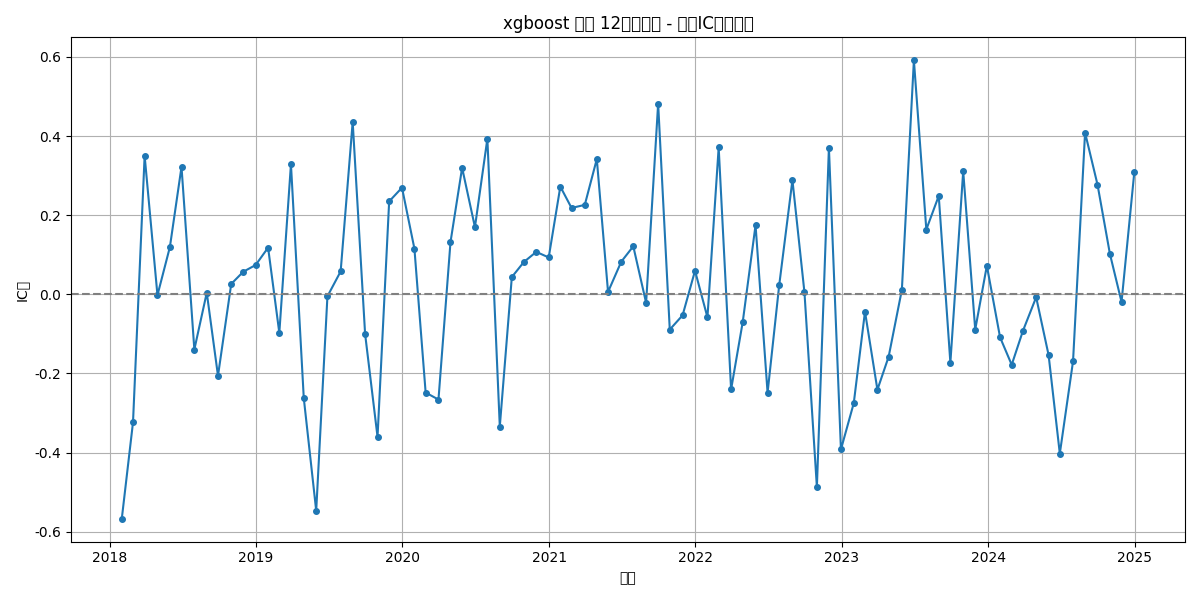

In [7]:
import matplotlib.pyplot as plt
from IPython.display import Image, display

def show_results_for_model(model_name, window):
    """显示指定模型的结果图表"""
    pred_img = f"outputs/results/pred_vs_real_{model_name}_{window}.png"
    ic_img = f"outputs/results/cs_ic_{model_name}_{window}.png"

    if os.path.exists(pred_img):
        print(f"\n{model_name} ({window}个月窗口) - 预测vs真实值")
        display(Image(filename=pred_img))

    if os.path.exists(ic_img):
        print(f"\n{model_name} ({window}个月窗口) - IC时间序列")
        display(Image(filename=ic_img))

# 显示第一个模型的结果作为示例
if all_results:
    first_result = all_results[0]
    show_results_for_model(first_result['model'], first_result['window'])

## 8. 输出文件说明

运行完成后，将在`outputs/`目录生成以下文件：

```
outputs/
├── results/
│   ├── all_results.csv       # 所有模型评估结果汇总
│   ├── pred_vs_real_*.png    # 预测与真实值对比图
│   ├── cs_ic_*.png           # IC时间序列图
│   └── top_etfs_*.csv        # 选中的ETF列表
└── models/                   # 保存的模型文件（可选）
```